In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, FastICA
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.random_projection import GaussianRandomProjection
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import validation_curve, learning_curve, train_test_split,GridSearchCV

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')



In [2]:
email_data = pd.read_csv("./spambase.csv")
# exclude id column
email_input = email_data.iloc[:, 1:-1]
email_target = email_data.iloc[:, -1]
mobile_data = pd.read_csv("./mobile_price.csv")
mobile_input = mobile_data.iloc[:, :-1]
mobile_target = mobile_data.iloc[:, -1]
ss = MinMaxScaler()

email_scaled_input = ss.fit_transform(email_input)
mobile_scaled_input = ss.fit_transform(mobile_input)
#
# email_train_input, email_test_input, email_train_target, email_test_target = train_test_split(email_input, email_target,random_state = 42, test_size=0.3)
# email_strain_input = ss.fit_transform(email_train_input)
# email_stest_input = ss.fit_transform(email_test_input)
#
# mobile_train_input, mobile_test_input, mobile_train_target, mobile_test_target = train_test_split(mobile_input, mobile_target,random_state = 42, test_size=0.3)
# mobile_strain_input = ss.fit_transform(mobile_train_input)
# mobile_stest_input = ss.fit_transform(mobile_test_input)

#Mobile {'hidden_layer_sizes': 2, 'learning_rate_init': 0.01}
#Email {'hidden_layer_sizes': 8, 'learning_rate_init': 0.002}

In [3]:
def data_refine(input, target):
    return train_test_split(input, target)


def find_best_params(input, target,cv=5):
    input, _, target, _ = data_refine(input, target)
    nn = MLPClassifier(max_iter=300,random_state=42)
    nn_param_names = ['learning_rate_init','hidden_layer_sizes']#,
    nn_param_ranges = [np.linspace(0.001, 0.01,10), range(2,10,1)]
    params = dict(zip(nn_param_names,nn_param_ranges))
    gs=GridSearchCV(nn,params, n_jobs=-1, cv=cv)
    gs.fit(input, target)
    best_index = np.argmax(gs.cv_results_['mean_test_score'])
    print(gs.cv_results_['params'][best_index])
    print(gs.best_score_)
    return gs.best_estimator_

def report(learners, inputs, target):
    trainning_times = []
    test_times = []
    train_scores = []
    test_scores = []
    x_label = ['Original','PCA','ICA', 'Random Projection', 'Feature Selection']


    for i in range(len(learners)):
        train_input, test_input, train_target, test_target = data_refine(inputs[i], target)
        train_size, train_score, test_score = learning_curve(learners[i],train_input, train_target, train_sizes=np.linspace(0.1,1,10),cv=5)
        plt.figure()
        plt.plot(train_size,np.mean(train_score,axis=1), label="Train Score")
        plt.plot(train_size,np.mean(test_score,axis=1), label="CV Score")
        plt.title(f'Learning Curve Neural Network with {x_label[i]} feature')
        plt.legend(loc='best')
        plt.xlabel("Trainning example(%)")
        plt.ylabel("Score")
        plt.show()

        start = time.time()
        learners[i].fit(train_input, train_target)
        end = time.time()
        trainning_times.append(end-start)
        train_score = learners[i].score(train_input, train_target)
        start = time.time()
        test_score = learners[i].score(test_input, test_target)
        end = time.time()
        test_times.append(end - start)
        train_scores.append(train_score)
        test_scores.append(test_score)

        plt.figure()
        plt.title(f'Loss Curve Neural Network with {x_label[i]} features')
        plt.plot(learners[i].loss_curve_)
        plt.xlabel("epoch")
        plt.ylabel("Loss")
        plt.show()


    # Show barplot trainning time comparision
    x_label = ['Original','PCA','ICA', 'Rand Proj', 'Feat Sel']
    plt.figure(figsize=(7,6))
    plt.bar(x_label, trainning_times)
    for i, v in enumerate(trainning_times):
        plt.text(i- 0.2, v+0.002 ,str(round(v,4)))
    plt.xlabel('Dimension Reduction')
    plt.ylabel('Time')
    plt.title('Trainning time by Dimension Reduction')
    plt.show()

    # Show barplot test time comparision
    # plt.figure(figsize=(7,6))
    # plt.title('Query time by Dimension Reduction')
    # plt.bar(x_label, test_times)
    # for i, v in enumerate(test_times):
    #     plt.text(i-0.2, v,str(round(v,6)))
    # plt.xlabel('Dimension Reduction')
    # plt.ylabel('Time')
    # plt.show()

    plt.figure(figsize=(7,6))
    plt.title('Number of Feature vs Dimension Reduction')
    plt.bar(x_label, [n.shape[1] for n in inputs])
    for i, v in enumerate([n.shape[1] for n in inputs]):
        plt.text(i-0.1, v, str(v))
    plt.xlabel('Dimension Reduction')
    plt.ylabel('Num of Features')
    plt.show()

    # Show barplot accuracy scores
    ind = np.arange(len(x_label) )
    width = 0.35
    plt.figure(figsize=(10,8))
    plt.bar(ind, (train_scores), width, label='Train Score')
    plt.bar(ind + width, (test_scores), width,label='Test Score')
    for i, v in enumerate(train_scores):
        plt.text(i-0.1, v+0.005 ,str(round(v,2)))
    for i, v in enumerate(test_scores):
        plt.text(i+width-0.1, v+0.005 ,str(round(v,2)))
    plt.xlabel('Dimension Reductions')
    plt.ylabel('Accuracy score')
    plt.title('Accuracy score by Dimension Reductions')

    plt.xticks(ind + width / 2, x_label)
    plt.legend(loc='best')


# Neural Network with Dimension Reduction

### Email

In [4]:
pca_email = PCA(n_components=34, random_state=42)
pca_email_reduced = pca_email.fit_transform(email_scaled_input)
# pca_email_nn = find_best_params(pca_email_reduced, email_target)
# {'hidden_layer_sizes': 9, 'learning_rate_init': 0.009000000000000001}
# 0.928695652173913

In [5]:
ica_email = FastICA(n_components=14, whiten=True, random_state=42)
ica_email_reduced = ica_email.fit_transform(email_scaled_input)
# ica_email_nn = find_best_params(ica_email_reduced, email_target)
# {'hidden_layer_sizes': 6, 'learning_rate_init': 0.007}
# 0.9055072463768117

In [6]:
rp_email = GaussianRandomProjection(n_components=5, random_state=42)
rp_email_reduced =  rp_email.fit_transform(email_scaled_input)
# rp_email_nn = find_best_params(rp_email_reduced, email_target)
# {'hidden_layer_sizes': 9, 'learning_rate_init': 0.007}
# 0.7431884057971014

In [7]:
clf_email = DecisionTreeClassifier()
clf_email.fit(email_scaled_input, email_target)
trans_email = SelectFromModel(clf_email, threshold='mean')
email_trans = trans_email.fit_transform(email_scaled_input, email_target)
# dt_email_nn = find_best_params(email_trans, email_target)
# {'hidden_layer_sizes': 5, 'learning_rate_init': 0.01}
# 0.9339130434782609

In [8]:
original_nn = MLPClassifier(max_iter=300,random_state=42, hidden_layer_sizes=8, learning_rate_init=0.002)
# {'hidden_layer_sizes': 8, 'learning_rate_init': 0.002}
# 0.9335403726708075

pca_email_nn_copy = MLPClassifier(max_iter=300,random_state=42, hidden_layer_sizes=8, learning_rate_init=0.002)
ica_email_nn_copy = MLPClassifier(max_iter=300,random_state=42, hidden_layer_sizes=6, learning_rate_init=0.007)
rp_email_nn_copy = MLPClassifier(max_iter=300,random_state=42, hidden_layer_sizes=9, learning_rate_init=0.007)
dt_email_nn_copy = MLPClassifier(max_iter=300,random_state=42, hidden_layer_sizes=9, learning_rate_init=0.01)
learners = [original_nn, pca_email_nn_copy, ica_email_nn_copy, rp_email_nn_copy, dt_email_nn_copy]
inputs = [email_scaled_input, pca_email_reduced, ica_email_reduced, rp_email_reduced, email_trans]

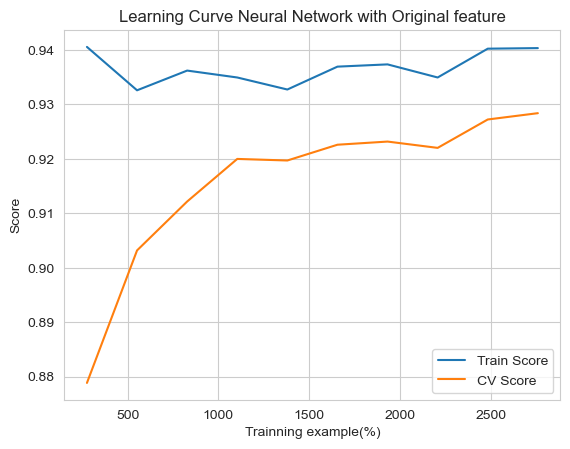

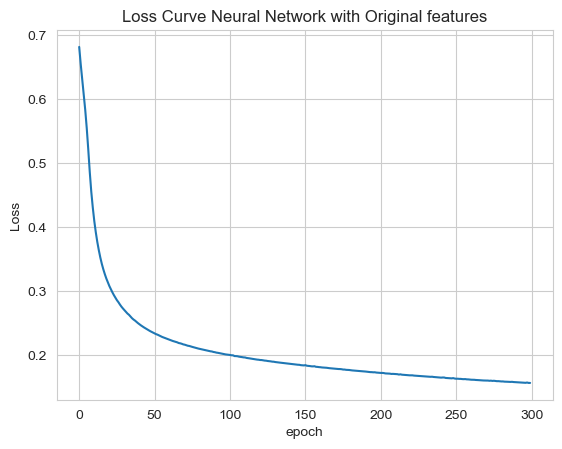

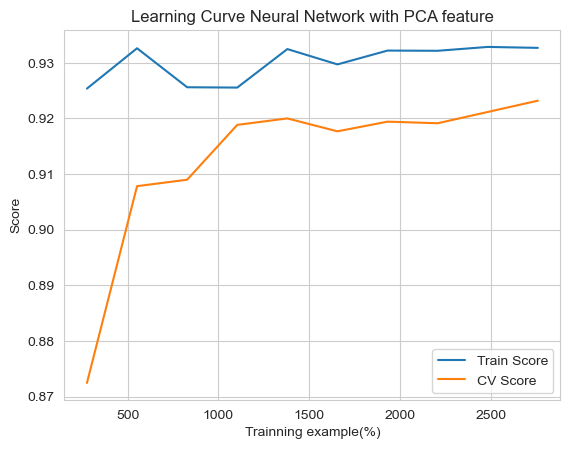

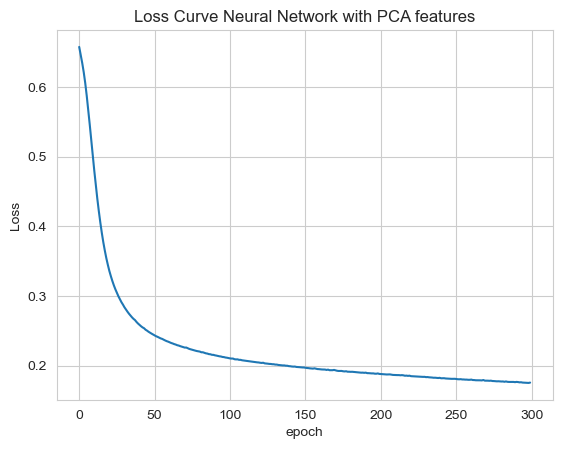

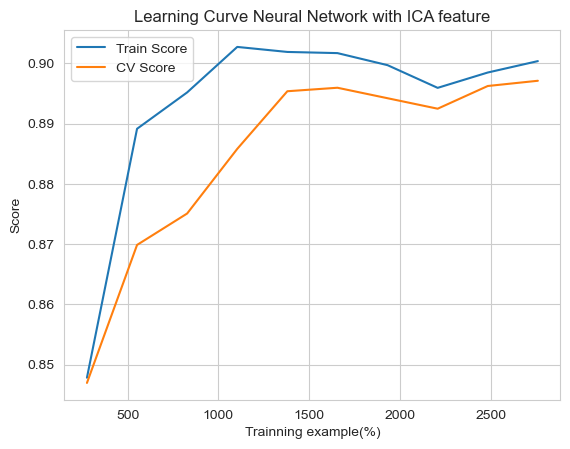

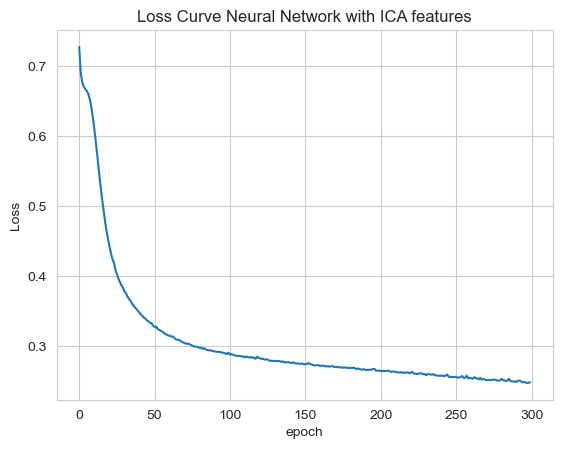

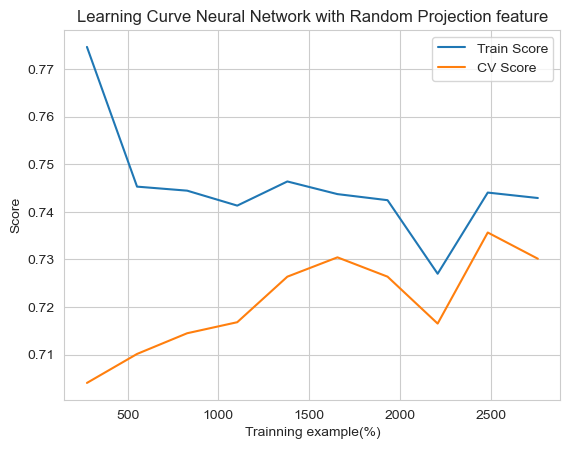

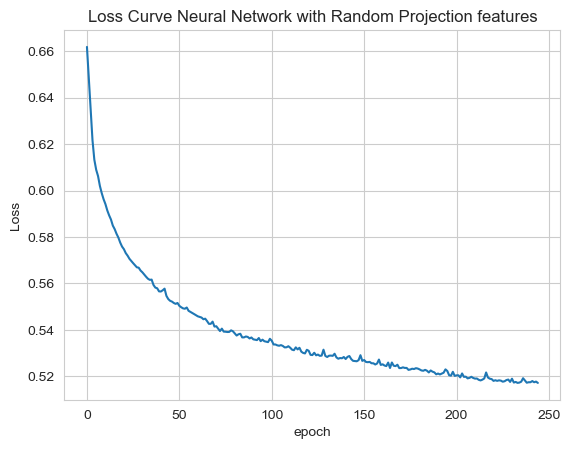

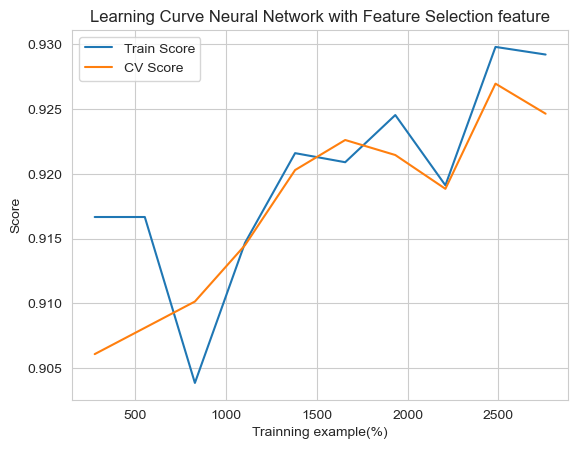

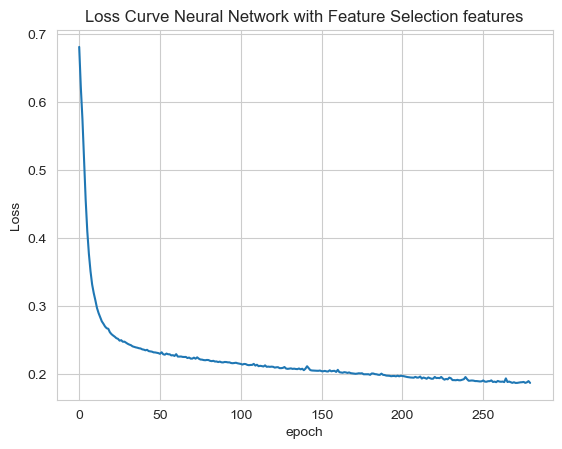

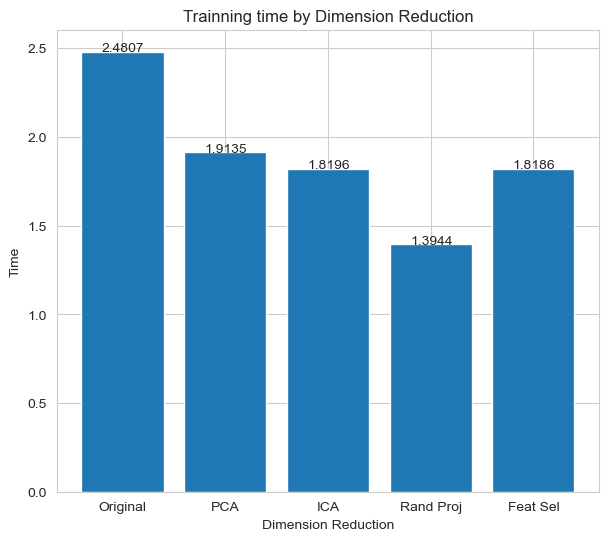

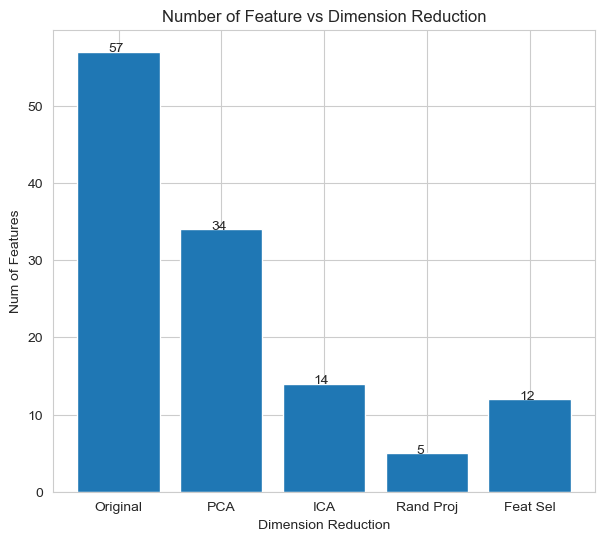

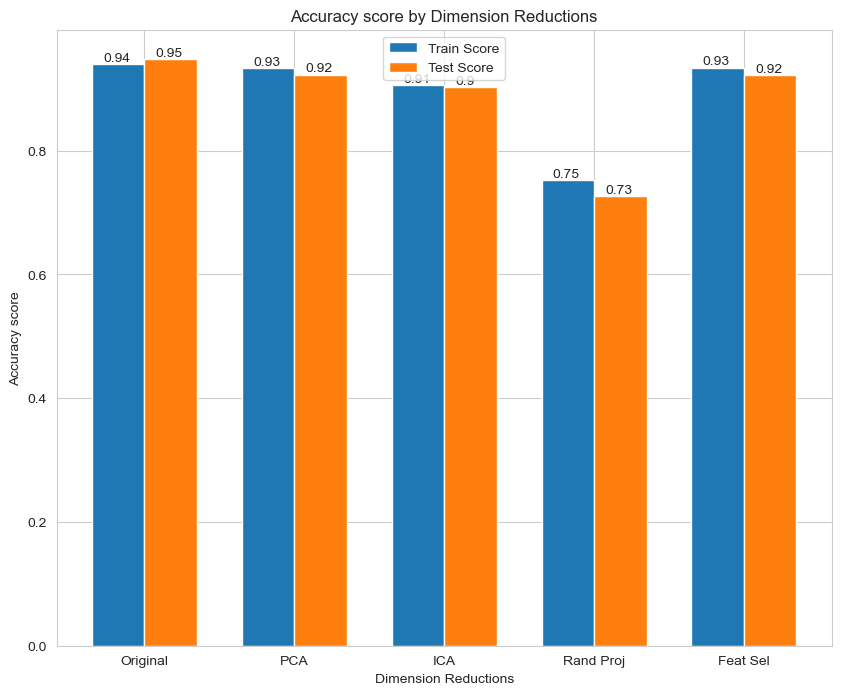

In [9]:
report(learners, inputs, email_target)

In [10]:
pca_mobile = PCA(n_components=15, random_state=42)
pca_mobile_reduced = pca_mobile.fit_transform(mobile_scaled_input)
# pca_mobile_nn = find_best_params(pca_mobile_reduced, mobile_target)
# {'hidden_layer_sizes': 9, 'learning_rate_init': 0.01}
# 0.8206666666666667

In [11]:
ica_mobile = FastICA(n_components=5, whiten=True, random_state=42)
ica_mobile_reduced = ica_mobile.fit_transform(mobile_scaled_input)
# ica_mobile_nn = find_best_params(ica_mobile_reduced, mobile_target)
# {'hidden_layer_sizes': 8, 'learning_rate_init': 0.008}
# 0.2753333333333334

In [12]:
rp_mobile = GaussianRandomProjection(n_components=11, random_state=42)
rp_mobile_reduced =  rp_mobile.fit_transform(mobile_scaled_input)
# rp_mobile_nn = find_best_params(rp_mobile_reduced, mobile_target)
# {'hidden_layer_sizes': 5, 'learning_rate_init': 0.003}
# 0.4806666666666667

In [13]:
clf_mobile = DecisionTreeClassifier(random_state=42)
clf_mobile.fit(mobile_scaled_input, mobile_target)
trans_mobile = SelectFromModel(clf_mobile, threshold='mean')
mobile_trans = trans_mobile.fit_transform(mobile_scaled_input, mobile_target)
# dt_mobile_nn = find_best_params(mobile_trans, mobile_target)
# {'hidden_layer_sizes': 7, 'learning_rate_init': 0.006}
# 0.9686666666666668

In [14]:
original_mobile_nn = MLPClassifier(max_iter=300,random_state=42, hidden_layer_sizes=2, learning_rate_init=0.01)
# {'hidden_layer_sizes': 2, 'learning_rate_init': 0.01}
# 0.9671428571428571

pca_mobile_nn_copy = MLPClassifier(max_iter=300,random_state=42, hidden_layer_sizes=9, learning_rate_init=0.01)
ica_mobile_nn_copy = MLPClassifier(max_iter=300,random_state=42, hidden_layer_sizes=8, learning_rate_init=0.008)
rp_mobile_nn_copy = MLPClassifier(max_iter=300,random_state=42, hidden_layer_sizes=5, learning_rate_init=0.003)
dt_mobile_nn_copy = MLPClassifier(max_iter=300,random_state=42, hidden_layer_sizes=7, learning_rate_init=0.006)
mobile_learners = [original_mobile_nn, pca_mobile_nn_copy, ica_mobile_nn_copy, rp_mobile_nn_copy, dt_mobile_nn_copy]
mobile_inputs = [mobile_scaled_input, pca_mobile_reduced, ica_mobile_reduced, rp_mobile_reduced, mobile_trans]

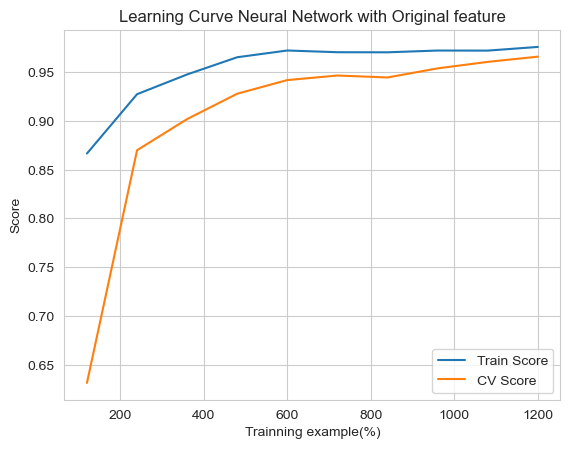

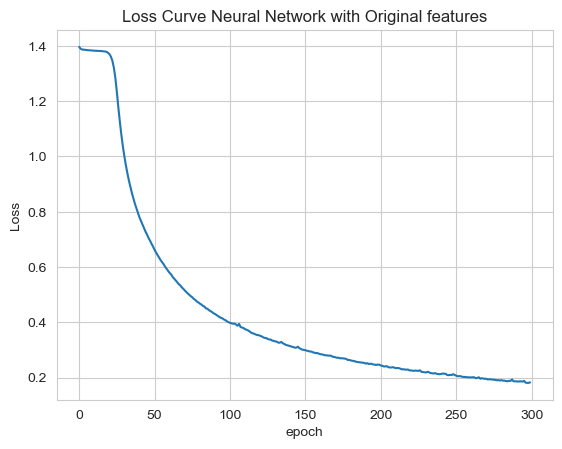

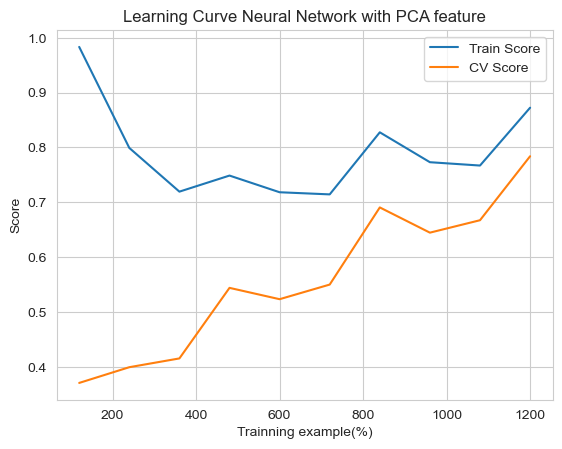

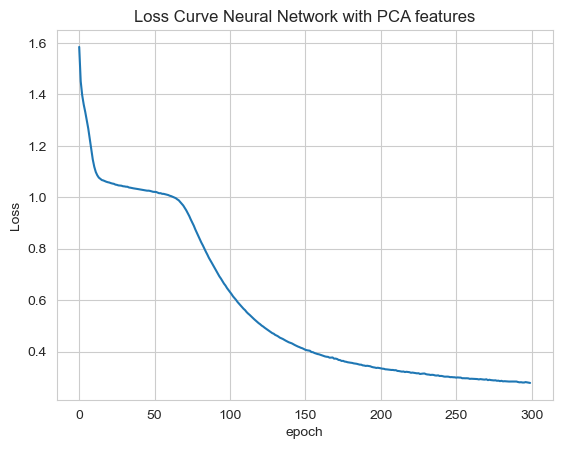

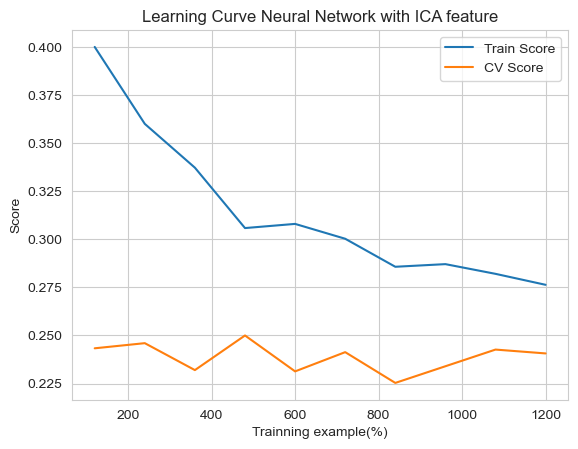

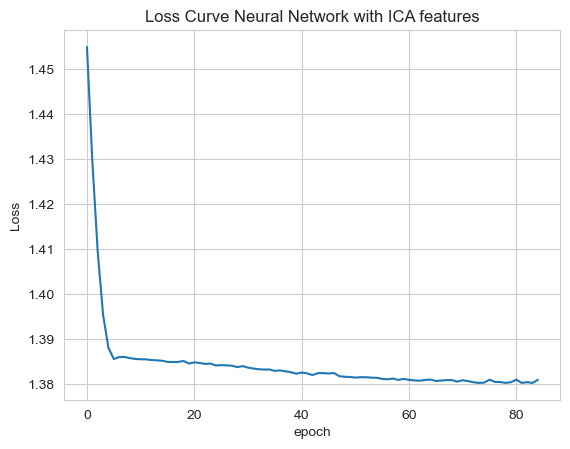

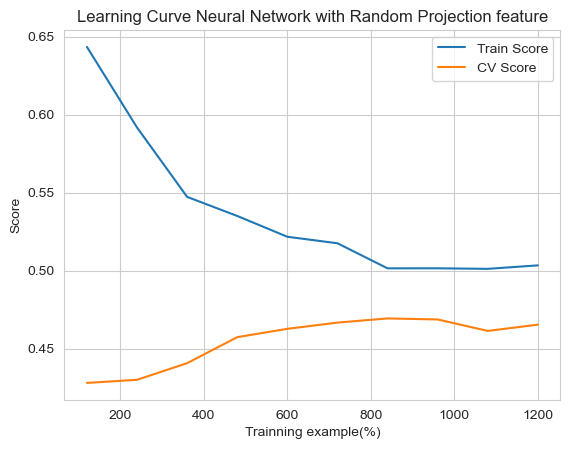

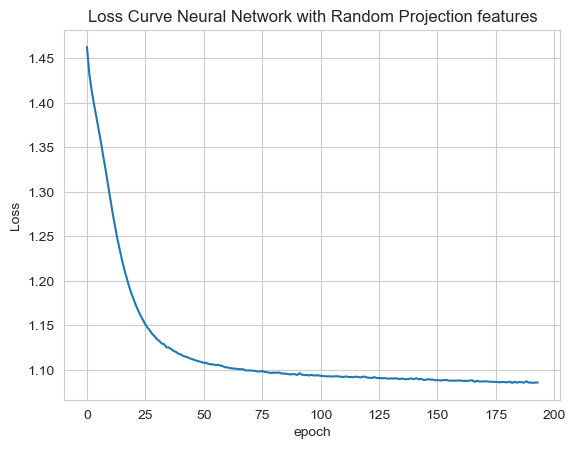

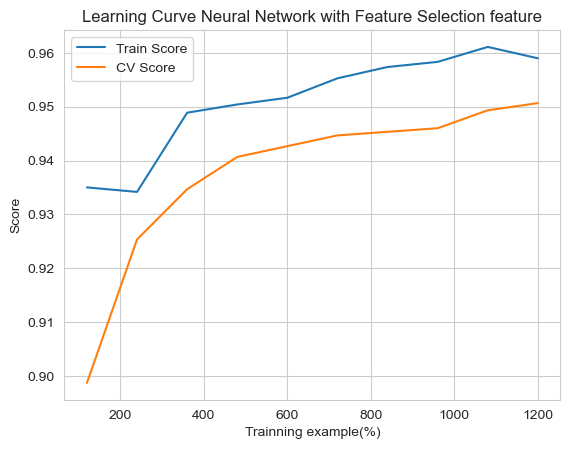

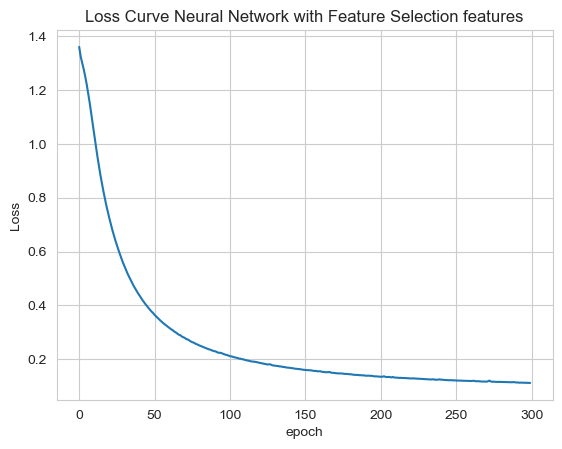

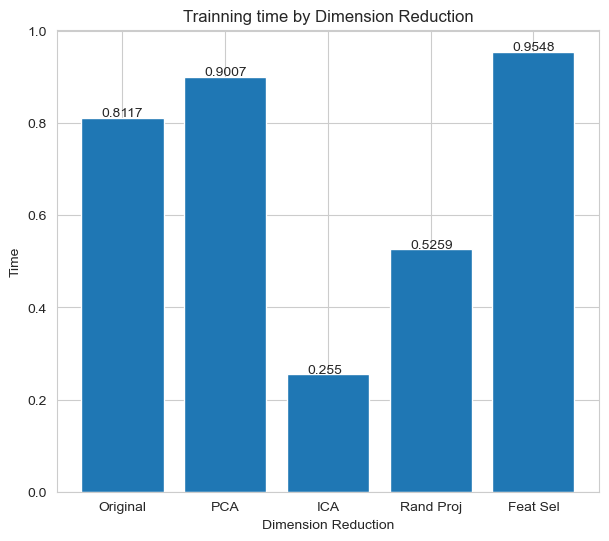

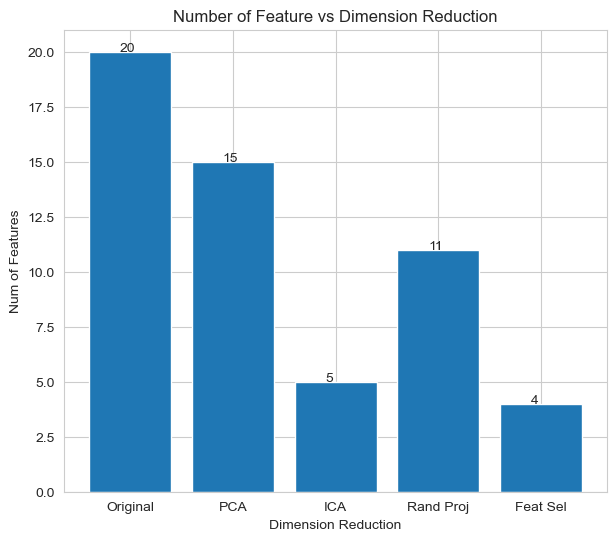

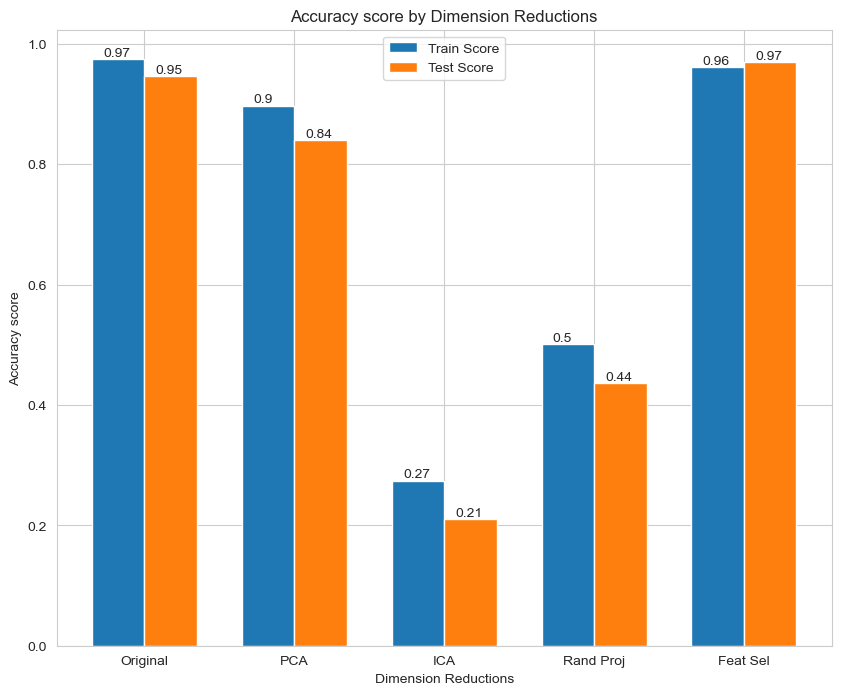

In [15]:
report(mobile_learners, mobile_inputs, mobile_target)